### Data Exploration for the Twitter Election Interference Dataset (IRA)

#### Data Import

In [2]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

load_new = False

pd.set_option('max_colwidth', 100)
plt.rcParams['figure.figsize'] = (12,10)

Let's start with reading in the data first. I failed to read the full dataset in, since it's too big (almost 6GB). Loading a subset in we can see that many tweets are in cyrillic or not in english. Since we can only sensibly work in english, we can immediately start reducing the amount of data by only loading the english tweets.

In [3]:
if load_new: 
    
    # Read in data, immediately discard rows with non-english tweets, iterator yields iterators object
    tweet_chunks =  pd.read_csv("../data/ira_tweets_csv_hashed.csv",iterator = True, chunksize = 10000)

    # Concatentate all chunks, filtering for english tweets
    tweet_data = pd.concat([chunk[chunk['tweet_language'] == "en"] for chunk in tweet_chunks])
    
    # Save
    tweet_data.to_csv("../data/ira_tweets_en.csv")

else:
    tweet_data = pd.read_csv("../data/ira_tweets_en.csv")

/home/adam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
user_data = pd.read_csv("../data/ira_users_csv_hashed.csv")


Index(['userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language'],
      dtype='object')

##### Data Exploration

The information on the columns can be found here https://storage.googleapis.com/twitter-election-integrity/hashed/Twitter_Elections_Integrity_Datasets_hashed_README.txt 

In [8]:
print(tweet_data.columns)
print(user_data.columns)

Index(['Unnamed: 0', 'tweetid', 'userid', 'user_display_name',
       'user_screen_name', 'user_reported_location',
       'user_profile_description', 'user_profile_url', 'follower_count',
       'following_count', 'account_creation_date', 'account_language',
       'tweet_language', 'tweet_text', 'tweet_time', 'tweet_client_name',
       'in_reply_to_tweetid', 'in_reply_to_userid', 'quoted_tweet_tweetid',
       'is_retweet', 'retweet_userid', 'retweet_tweetid', 'latitude',
       'longitude', 'quote_count', 'reply_count', 'like_count',
       'retweet_count', 'hashtags', 'urls', 'user_mentions', 'poll_choices'],
      dtype='object')
Index(['userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language'],
      dtype='object')


In [9]:
len(tweet_data.tweetid.unique())

2997181

Seems like all tweets are unique! How many users do we have?

In [10]:
len(tweet_data.userid.unique())

3077

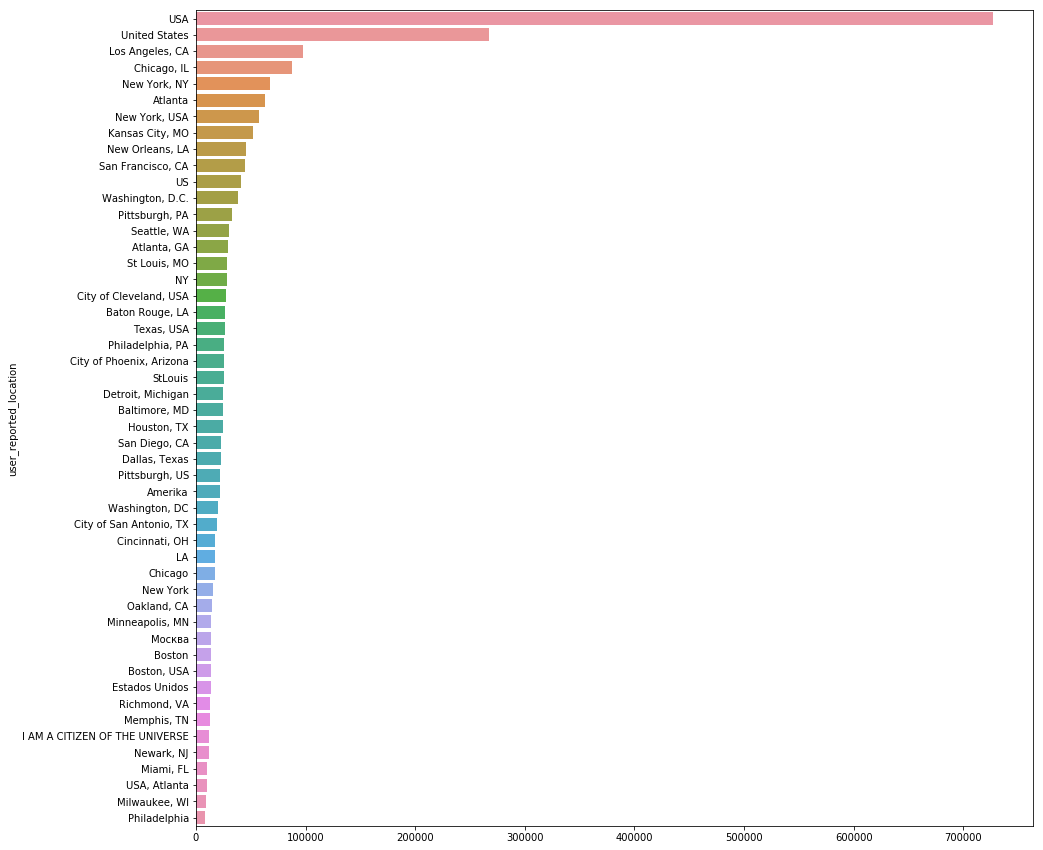

In [12]:
tweet_location = tweet_data.groupby("user_reported_location").count().sort_values("tweetid",ascending = False)
plt.figure(figsize=(15, 15))
sns.barplot(y= tweet_location.iloc[0:50,0].index, x=tweet_location.iloc[0:50,0].values)

Interesting, 12400 "CITIZENS OF THE UNIVERSE". I wonder whether they all know each other.
Many of them just state USA, which seems a bit ood. We can later check their behaviour by location. 

---

Let's look at most active users

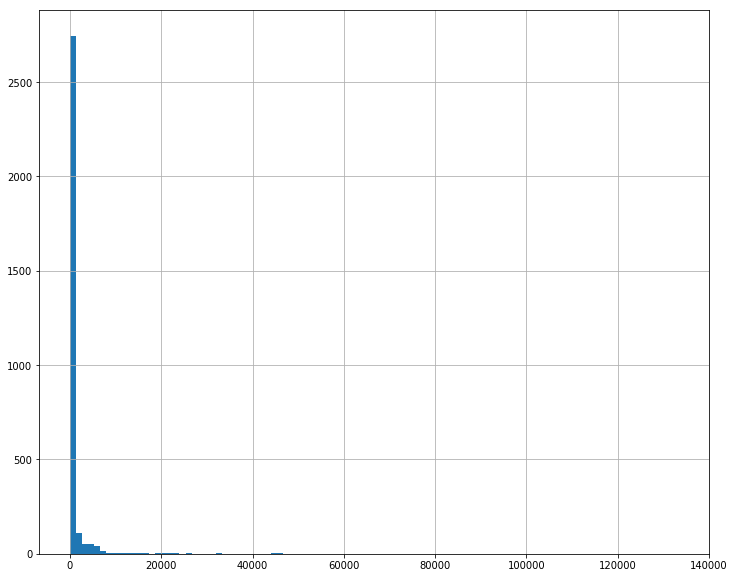

In [13]:
tweet_data['user_display_name'].value_counts().hist(bins = 100)

In [14]:
most_active = tweet_data['userid'].value_counts().iloc[0:1000]

Seems there is a "super active" user, let's find out more about it. Let's show some of his/her tweets.

In [15]:
most_active_user_tweets = tweet_data[tweet_data["userid"] == most_active.index[0]]["tweet_text"]
most_active_user_tweets.sample(5)

32233      RT @joshdcaplan: SCOOP: GOP challenger Omar Navarro @PressGop calls out @MaxineWaters for interf...
2429271    RT @theoptionoracle: #ItReallyOffendsMe when you piss on my Rice Krispies. #DumpKelloggs and #Bo...
2743165    RT @FoxNews: #HeatherHeyer's Mother Susan Bro: "I'd rather have my child but, by golly, if I got...
2142221    RT @WayneDupreeShow: LIVE: WDShow 5-17 ICE Rounding Up Illegals; Dems Have Rabies 202 733 6951 o...
1816459    RT @dagenmcdowell: #BullsandBears is Brenda Buttner's show. Always + forever. B, we try to make ...
Name: tweet_text, dtype: object

Let's look at the ratio RT vs content provider of most active users

In [16]:
users = most_active.index[0:100]
#tweet_data.userid.unique()[:100]
is_content_provider = []

for user in users:

    retweets = tweet_data[tweet_data["userid"] == user]["is_retweet"]
    is_content_provider.append(retweets.sum()/len(retweets))
    
is_content_provider = pd.DataFrame(is_content_provider, index=users, columns = ["ratio"])

In [ ]:
is_content_provider.plot.bar()

I would say there are clear content providers, the ones with lower rate and content spreaders, the ones with higher rate.

In [ ]:
ret_users = tweet_data[tweet_data["userid"].isin(tweet_data.userid)]['retweet_userid'].value_counts().index
tweet_data[tweet_data["userid"].isin(ret_users)]['tweetid'].count()/len(tweet_data)

OH .. what a surprise, they are retweeting one to each other 80% of the time.

---

Let's check when these accounts where created

In [ ]:
date_creation = user_data["account_creation_date"].value_counts().sort_index()
date_creation.index = pd.to_datetime(date_creation.index)
date_creation.plot()
plt.axvline(x=pd.to_datetime('08-11-2016'), color = 'red')

The account creation seem concentrated before the USA elections... but why are there some being created afterwards?

Let's check when there were more tweets.

In [ ]:
tweet_data.tweet_time = pd.to_datetime(tweet_data.tweet_time)
tweet_data = tweet_data.set_index('tweet_time')

In [ ]:
tweet_data["tweetid"].groupby(tweet_data.index.date).count().plot()
plt.axvline(x=pd.to_datetime('08-11-2016'), color = 'red')

Before USA elections seem to be high activity that climbs up again after elections.

In [ ]:
tweet_data["tweetid"].groupby(tweet_data.index.date).count().argmax()

What happened this day ?

---

What about most used hashtags?

In [ ]:
hashtags = tweet_data.hashtags.str.extractall(r'(\w+)')
hashtags = hashtags.reset_index("match").drop(columns = 'match')

In [ ]:
hashtags[0].value_counts()[:50].plot.bar()

In [ ]:
hashtags2 = hashtags.reset_index().set_index(['tweet_time',0])

In [ ]:
hashtags2.head()

---

What are the words used by this tios

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!
    
    clean_pattern = [r'(@\w+=?:?)', #Mentions
                     r'(RT)', # Retweets
                     r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', # urls
                     r'(https)', # left over
                     r'(  +)', #Extra spaces
                     r'(\n)', # Break lines
                     r'[(]|[)]',# Parenthesis 
                     r'(#\w+)', # tags
                     r'(&w\+)'] 
    
    clean_pattern = '|'.join(clean_pattern)
    s = re.sub(clean_pattern,'',s)    
    return s


# Simple exploration
vectorizer = CountVectorizer(lowercase = False,
                             preprocessor = clean_twitter,
                            stop_words = 'english',
                            ngram_range= (1,2))

In [ ]:
V = vectorizer.fit_transform(tweet_data[tweet_data["userid"].isin(most_active.index)]["tweet_text"])

In [ ]:
words = vectorizer.get_feature_names()
counts = V.sum(axis=0)

In [ ]:
most_used_words = pd.DataFrame(counts.T, index = words, columns = ["word_count"])
most_used_words.sort_values(by ='word_count',ascending=False).head(50).plot.bar()

IDEAS :

- Check words used for most active users
- MOst active user tweets date

# Embedding tweets for clustering

### Steps:
- strip jibberish
- tokenize
- stem
- embed
- cluster
- look for pattern
- cluster with labels (to-do!)

In [ ]:
from bs4 import BeautifulSoup
import re
import nltk

def clean_twitter_seb(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    
    # Jordi's regex kicks out all unwanted stuff
    clean_pattern = [r'(@\w+=?:?)', #Mentions
                     r'(RT)', # Retweets
                     r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', # urls
                     r'(https)', # left over
                     r'(  +)', #Extra spaces
                     r'(\n)', # Break lines
                     r'[(]|[)]',# Parenthesis 
                     r'(#\w+)', # tags
                     r'(&w\+)'] 
    
    clean_pattern = '|'.join(clean_pattern)
    s = re.sub(clean_pattern,'',s)    

    # Seb's pattern sort of does the same
    pattern = r"(?u)\b\w\w+\b"
    pattern = re.compile(pattern)
    
    # Together they work well! And return all expressions in s that match pattern
    return(pattern.findall(s))
    pass

## The raw data

In [ ]:
tweet_data.tweet_text

## Cleaning, stemming, tokenization

In [ ]:
# Use porter algorithm for stemming, seems to be commonly used
from nltk.stem.porter import *
stemmer = PorterStemmer()
# do all at once
tweets = [tokenize(stemmer.stem(clean_twitter_seb(i))) for i in tweet_data.tweet_text]

In [ ]:
# check the result

In [ ]:
tweets

## Train word vectors using Word2Vec

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(tweets, size=100, window=10, min_count=1, workers=8)
model.train(tweets, total_examples=1, epochs=2)

## Generate a word vector for each tweet

In [1]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0) 
    a /= np.linalg.norm(a)
    return a

In [ ]:
embed_w2v(tweets_in_dept)

In [ ]:
# use each model in turn to embed the individual reviews
w2v_matrix = np.array([embed_w2v(t, model) for t in tweets])

In [ ]:
w2v_matrix.shape

## Cluster based on the embedded vectors

In [ ]:
from sklearn.mixture import GaussianMixture as gm

In [ ]:
cluster = gm(2)
cluster.fit(X = w2v_matrix)

In [ ]:
result = cluster.predict(X = w2v_matrix)

In [ ]:
result.shape

## Check the reviews that have been clustered together

In [ ]:
bool_result = np.array(result, dtype=bool)

In [ ]:
tweet_data.tweet_text[bool_result].shape

In [ ]:
tweet_data.tweet_text[bool_result]

In [ ]:
tweet_data.tweet_text[~bool_result]

## Predict the probabilities with which the reviews belong to this cluster

In [ ]:
result_probs = cluster.predict_proba(X = w2v_matrix)

In [ ]:
result_probs.shape

In [ ]:
tweet_data.tweet_text.shape

In [ ]:
tweet_probs = np.concatenate((result_probs, tweet_data.tweet_text[:,None]), axis = 1)

In [ ]:
tweet_probs

## Based on the Russian bot vocab, which words are similar?

In [ ]:
display(model.wv.most_similar('trump'))
display(model.wv.most_similar('hillary'))
display(model.wv.most_similar('mexico'))
display(model.wv.most_similar('isis'))
display(model.wv.most_similar(positive=['trump'], negative=['hillary']))

## Let's also visualise this

In [ ]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

In [ ]:
idx = np.random.randint(0, len(tweet_data.tweet_text), size=5)
visualize_dist(w2v_matrix, tweet_data.tweet_text, idx)